In [45]:
%pip install tf_keras_vis tflite-support-nightly

  Using cached tf_keras_vis-0.8.7-py3-none-any.whl (52 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following versions that require a different python version: 0.2.0 Requires-Python >=3.5, <3.8; 0.2.1 Requires-Python >=3.5, <3.8; 0.2.3 Requires-Python >=3.5, <3.8; 0.2.4 Requires-Python >=3.5, <=3.8; 0.2.5 Requires-Python >=3.5, <3.9; 0.3.1 Requires-Python >=3.5, <3.9; 0.3.2 Requires-Python >=3.5, <3.9; 0.3.3 Requires-Python >=3.5, <3.9; 0.4.0 Requires-Python >=3.5, <3.9; 0.5.0 Requires-Python >=3.5, <3.9; 0.5.2 Requires-Python >=3.5, <3.9; 0.5.3 Requires-Python >=3.5, <3.9; 0.5.4 Requires-Python >=3.5, <3.9; 0.5.5 Requires-Python >=3.6, <3.9
ERROR: Could not find a version that satisfies the requirement tflite-support-nightly (from versions: none)
ERROR: No matching distribution found for tflite-support-nightly


# Create your dataset

1) Choose which classes you would like to add.

2) Create a dataset with your own photos

3) Separate your dataset into train and test subsets.

In [46]:
import os
import pandas as pd
from glob import glob

# Returns a dataframe of labeled image files
# Each row contains the path of a file and its category.
# Example : 'data\brewdog_hazyjane\20240522_152717.jpg', 'brewdog_hazyjane'
def get_labeled_filenames(path):
    data = []
    for directory_name in os.listdir(path):
        if not os.path.isfile(directory_name):
            directory_path = os.path.join(path, directory_name)
            for file in os.listdir(directory_path):
                data.append([os.path.join(directory_path, file), directory_name])
    return pd.DataFrame(data, columns = ["path", "label"])

In [47]:
DATA_DIR = "data"

labeled_filenames = get_labeled_filenames(DATA_DIR)

LABEL_NAMES = pd.unique(labeled_filenames['label'])
print(LABEL_NAMES)

['brewdog_hazyjane' 'el_tony_mate' 'fizzy_mirtillo' 'hoegaarden' 'swaf']


**TODO**: Display some images of your dataset

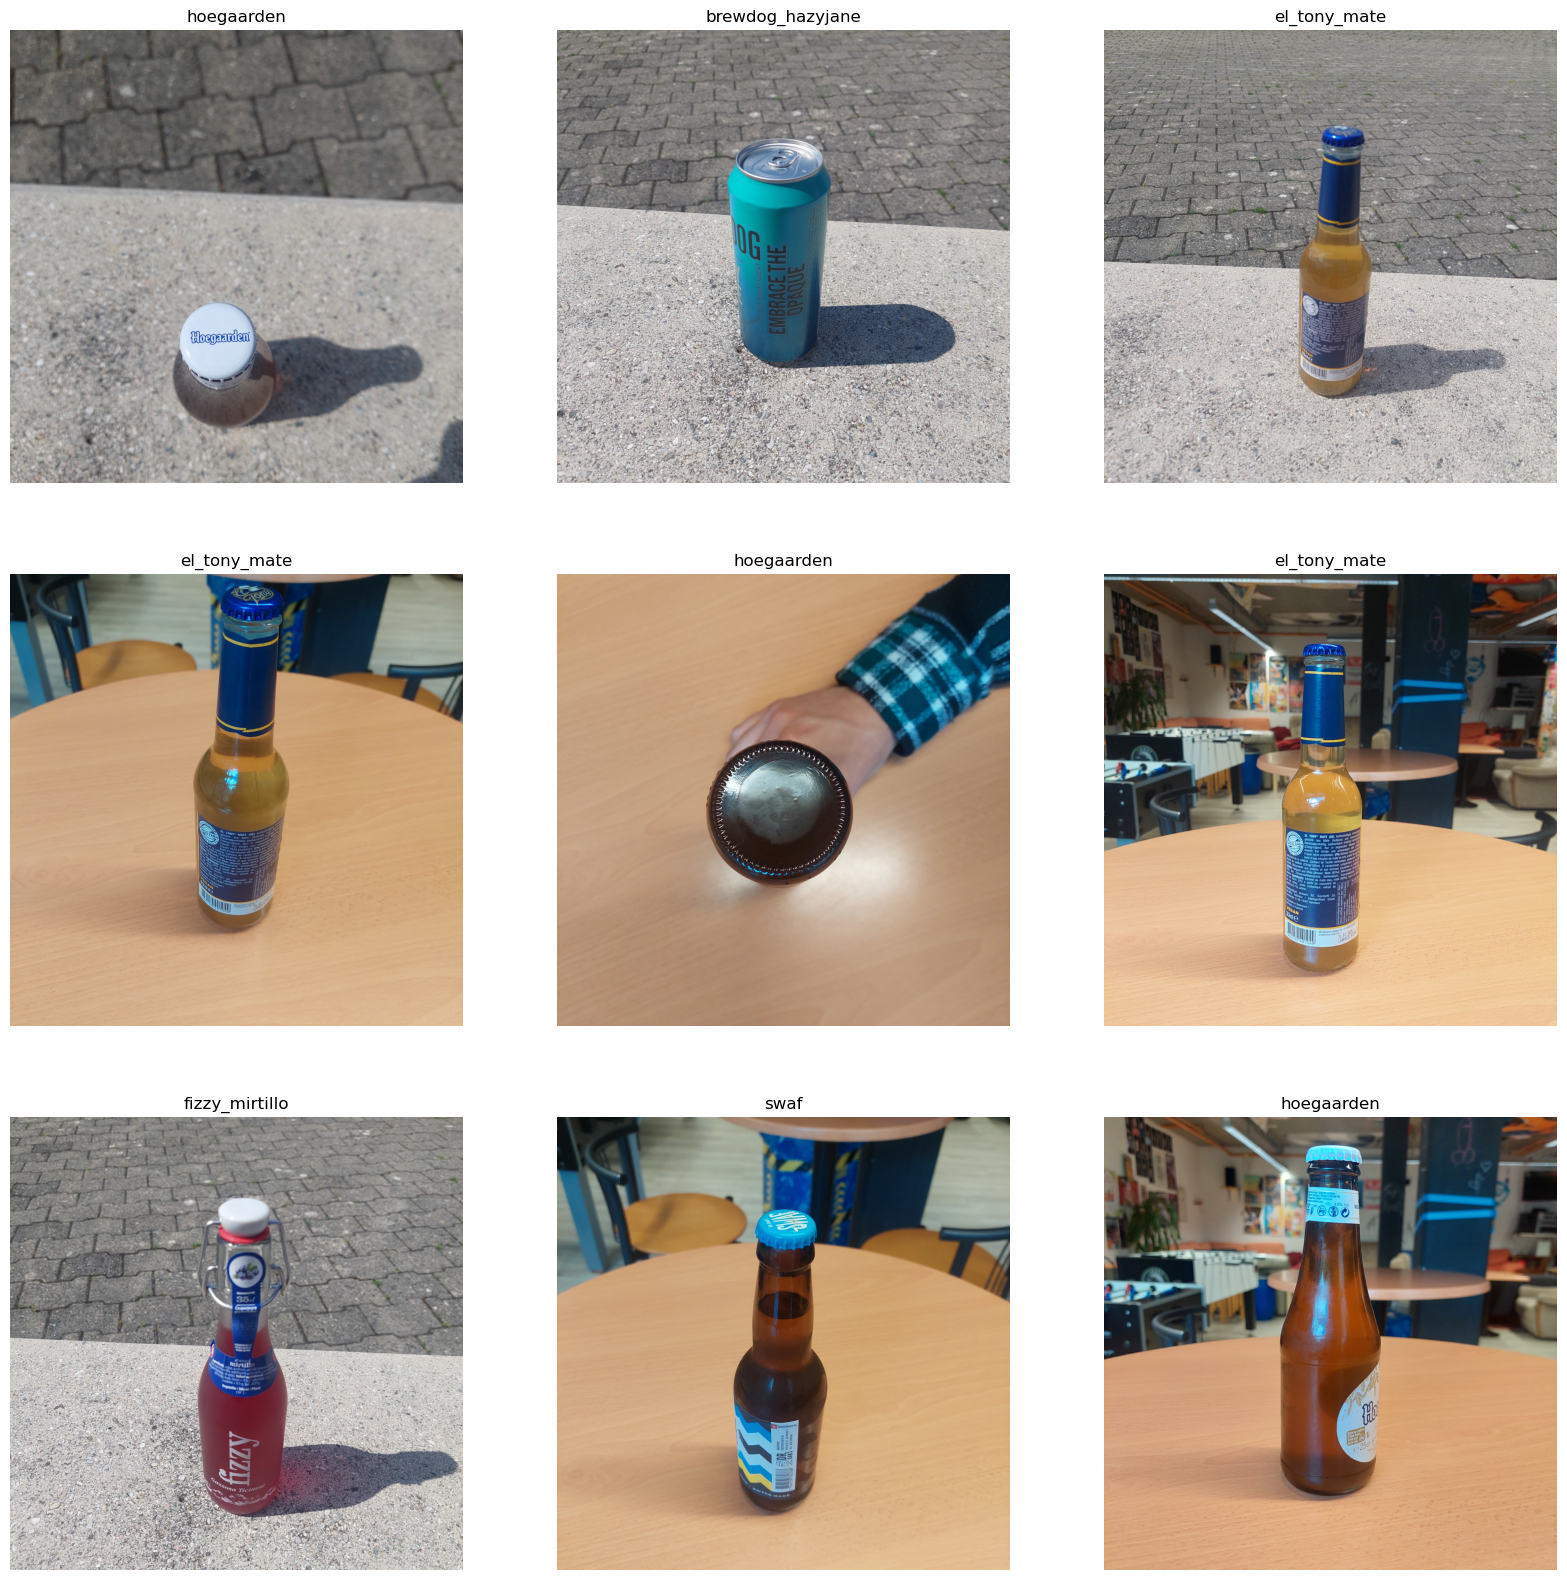

In [48]:
# Display some image of the dataset
import matplotlib.pyplot as plt
import PIL
import PIL.Image
 
plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in labeled_filenames.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path).rotate(-90))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

# Explore your dataset

**TODO**: count the number of examples per classes and plot an histogram of it

# Preprocessing steps

In [49]:
# Pre-processing functions

import numpy as np
import tensorflow.keras.layers as layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Resizing, Rescaling)

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation

    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.1),
    layers.RandomRotation(0.3),
    layers.RandomContrast(0.5),
])

def load_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))
    return opened_img

def load_all_images(paths):
    return np.stack([load_image(path) for path in paths])

def augment_images(images):
    return np.stack([image_augmentations(img) for img in images])

def add_n_augmented_images(images, labels, n):
    augmented_images = np.concatenate([augment_images(images) for i in range(n)])
    return np.concatenate([images, augmented_images]), np.concatenate([labels.repeat(n+1)])

In [50]:
# Split the dataset into train and test

from sklearn.model_selection import train_test_split

TEST_SET_RATIO = 0.2
SEED = 42
NUMBER_OF_AUGMENTATIONS = 3

X_train_path, X_test_path, y_train, y_test = train_test_split(labeled_filenames['path'], labeled_filenames['label'], test_size=TEST_SET_RATIO, random_state=SEED)

X_train_img_raw = load_all_images(X_train_path)
X_test_img = load_all_images(X_test_path)

# Augment images
X_train_img_augmented, y_train_labels = add_n_augmented_images(X_train_img_raw, y_train, NUMBER_OF_AUGMENTATIONS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


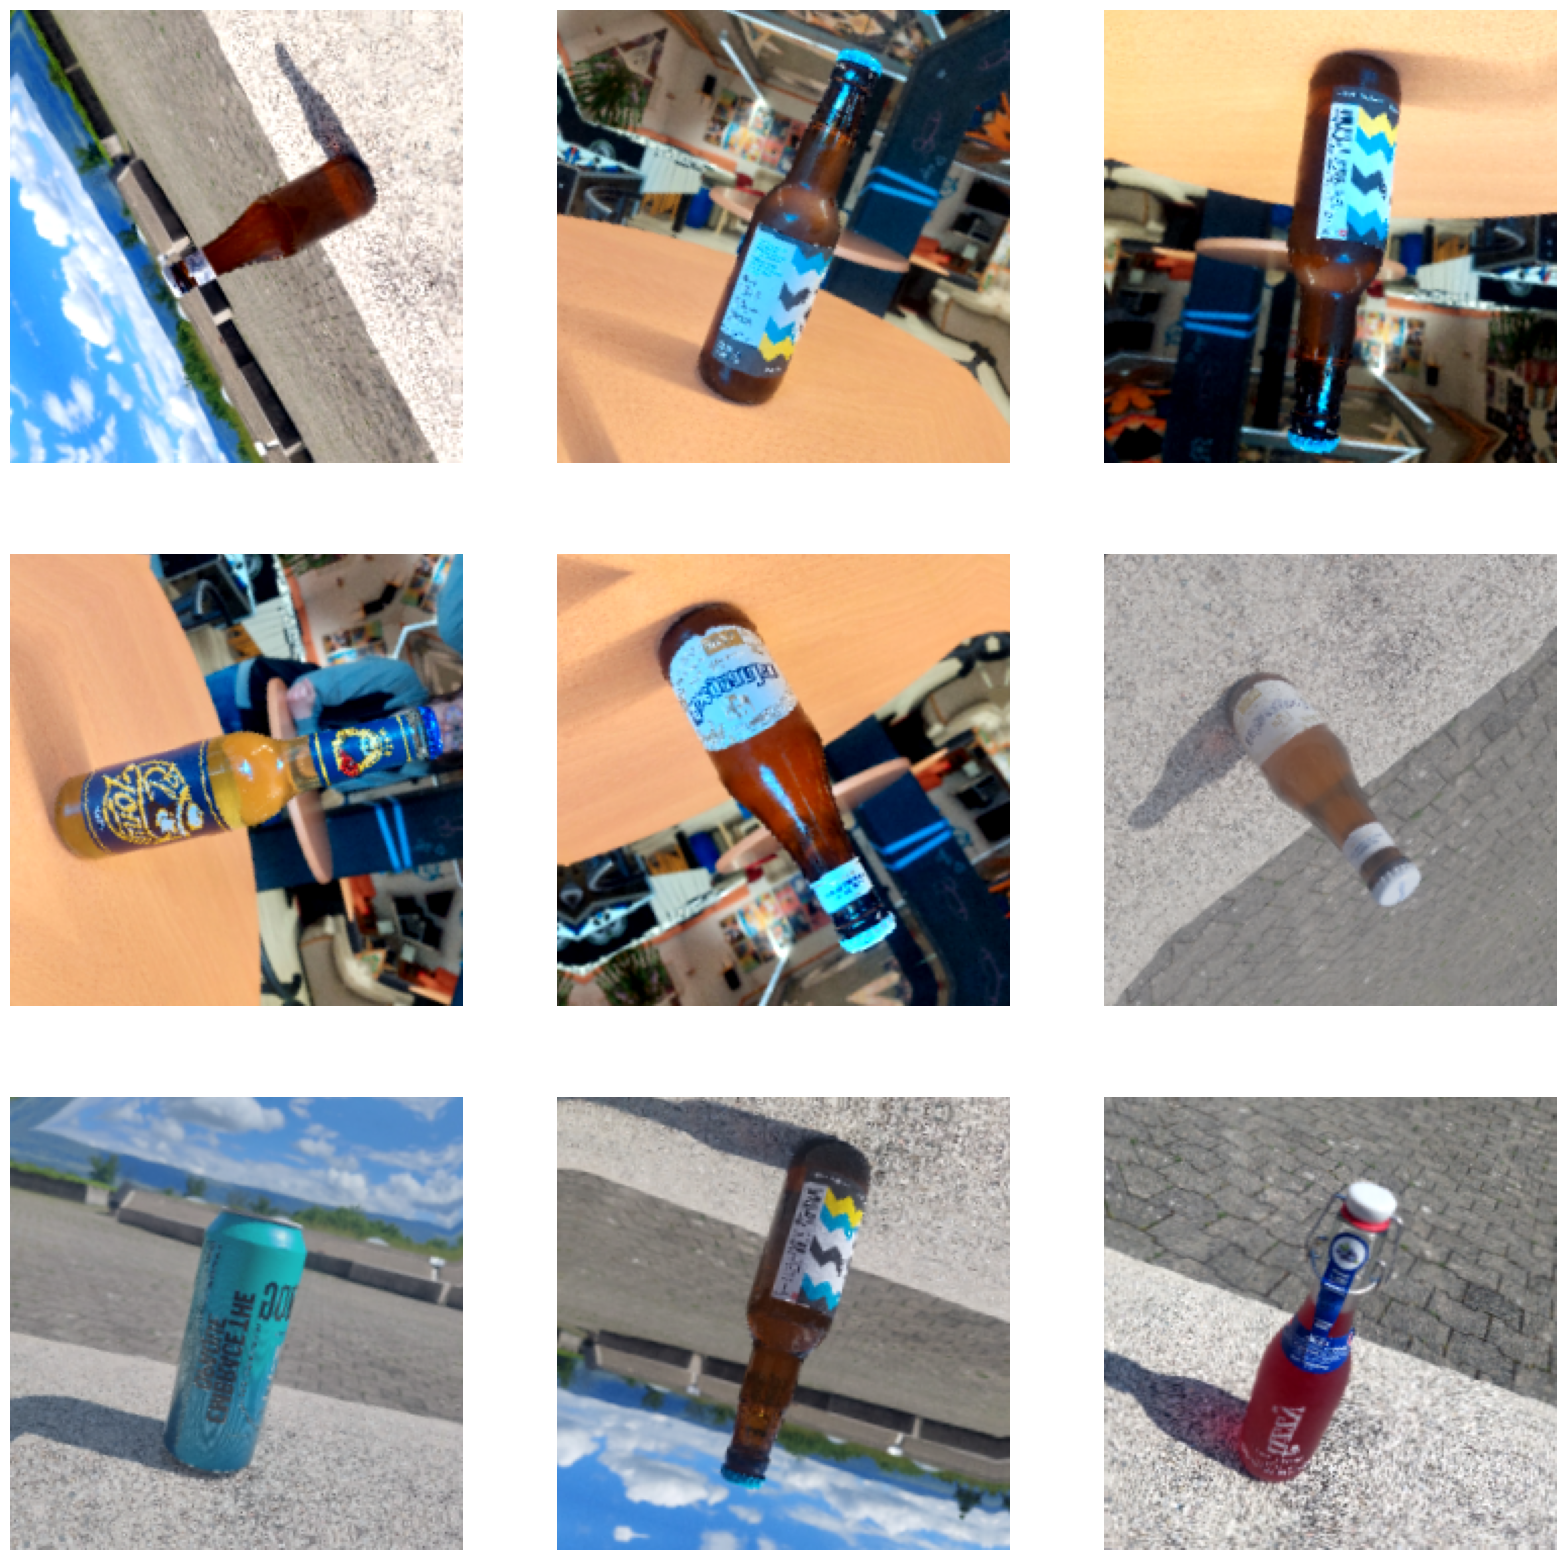

In [51]:
# Plot a few augmented images
plt.figure(figsize=(20, 20))
for i, img in enumerate(X_train_img_augmented[-9:]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")

## Define model

In [57]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    
    layers = base_model.output

    # TODO: freeze layers expt the last 5 layers
    for layer in base_model.layers[:-1]:
        layer.trainable = False


    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on 
        GlobalAveragePooling2D(),

        # TODO: ...
        Dense(10, activation='relu'),
        Dense(len(LABEL_NAMES), activation='softmax')
    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))
    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

model = get_model()
#model.summary()

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time 

In [58]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(LABEL_NAMES)
total_train_labels = label_encoder.transform(y_train_labels)
test_labels = label_encoder.transform(y_test)

NB_EPOCHS = 5
NB_FOLDS = 2

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=NB_FOLDS).split(X_train_img_augmented, total_train_labels):
    train_images = X_train_img_augmented[train_index]  
    train_labels = total_train_labels[train_index]
    
    val_images = X_train_img_augmented[val_index] 
    val_labels = total_train_labels[val_index]
    
    model = get_model() # We reinitialize the model
    
    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=32,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - acc: 0.1708 - loss: 1.8373 - val_acc: 0.1625 - val_loss: 1.7545
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 921ms/step - acc: 0.2883 - loss: 1.5335 - val_acc: 0.1437 - val_loss: 1.8818
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 931ms/step - acc: 0.3716 - loss: 1.4323 - val_acc: 0.1312 - val_loss: 1.7991
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 946ms/step - acc: 0.3821 - loss: 1.4122 - val_acc: 0.1437 - val_loss: 1.8617
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 992ms/step - acc: 0.3719 - loss: 1.3993 - val_acc: 0.1312 - val_loss: 2.0485
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - acc: 0.2227 - loss: 1.8035 - val_acc: 0.1000 - val_loss: 1.7459
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 836ms/step - acc: 0.3299 - loss: 1.5246 - val_acc: 0.1125 - val_loss: 1.9040
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 899ms/step - acc: 0.3520 - loss: 1.4802 - val_acc: 0.1000 - val_loss: 1.8101
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 997ms/step - acc: 0.4032 - loss: 1.4438 - val_ac

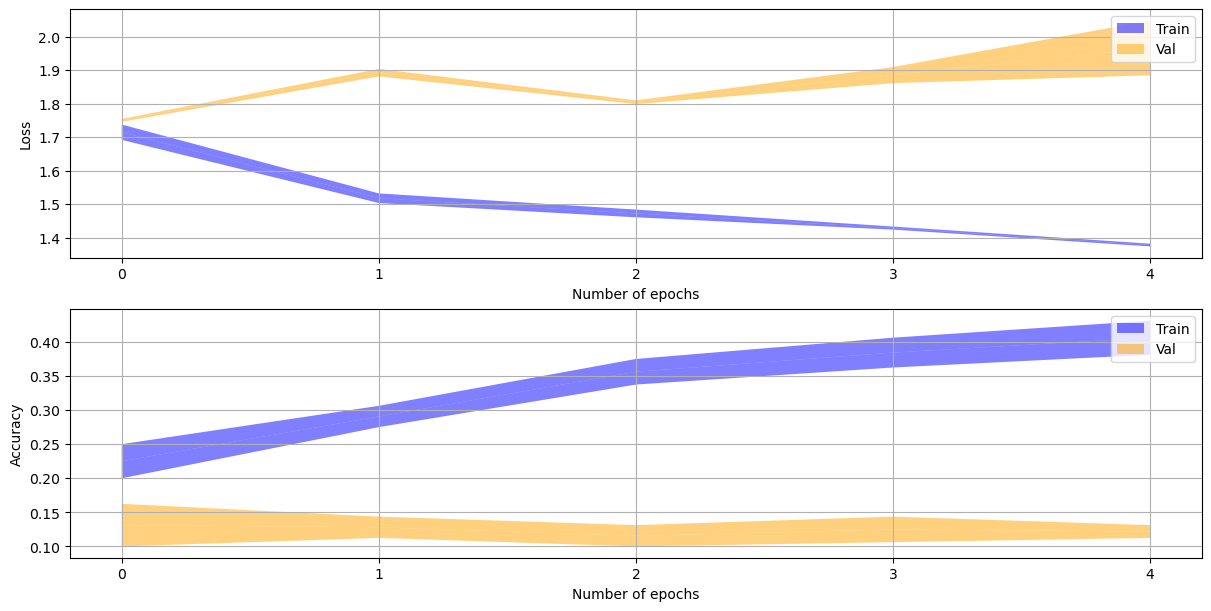

In [59]:
import matplotlib.pyplot as pl

def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - acc: 0.1633 - loss: 2.0141
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - acc: 0.2140 - loss: 1.5933
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - acc: 0.2377 - loss: 1.5902
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - acc: 0.2645 - loss: 1.5298
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 443ms/step - acc: 0.2868 - loss: 1.5522
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


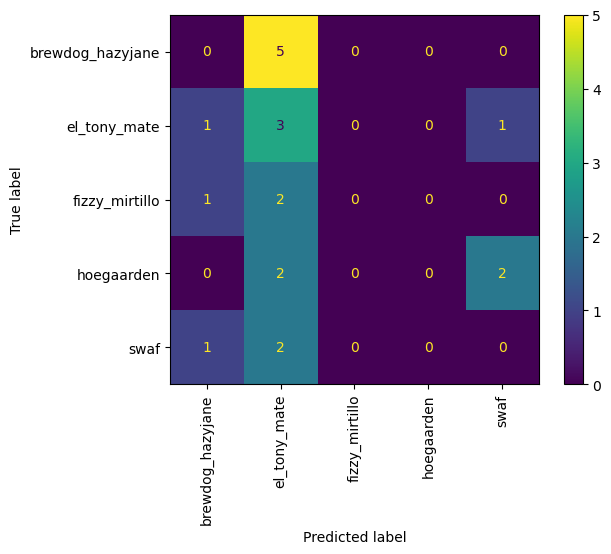

F1 score: 0.06315789473684211
Accuracy: 0.15


In [55]:
import sklearn.metrics as me

# First retrain model on all the training data
train_images = X_train_img_augmented    
train_labels = total_train_labels

model = get_model() # We reinitialize the model

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=32,
    epochs=NB_EPOCHS,
)

pred = model.predict(X_test_img)
pred = np.argmax(pred, axis=-1)

test_confusion_matrix = me.confusion_matrix(test_labels, pred, labels=np.arange(len(LABEL_NAMES)))

confusion_matrix_display = me.ConfusionMatrixDisplay(
    confusion_matrix=test_confusion_matrix,
    display_labels=LABEL_NAMES,
)

confusion_matrix_display.plot(xticks_rotation='vertical')
plt.show()

#F1 score and accuracy
f1 = me.f1_score(test_labels, pred, average='macro')
accuracy = me.accuracy_score(test_labels, pred)

print(f"F1 score: {f1}")
print(f"Accuracy: {accuracy}")

# Results

**TODO**: plot the results from your crossvalidation

## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

In [56]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 10

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
    
    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = load_image(rowdata.path)    
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1

ModuleNotFoundError: No module named 'tf_keras_vis'

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

**TODO**: try to determine what caused the misclassifcations and what you can do about it